# Setup

Lattice: MxM matrix with entries $N_i$
Update rule for $N_i$: $N_i^{(t+1)} = N_i^{t} + r N_i^{t}(1 - \frac{N_i^{t}}{P_i}) \Delta t$
Parameters: $r, \Delta t$

$P_i$ is the productivity and depends on the "match" between Environment $E_i$ and Population skills $G_i$. Both are binary vectors.
We have $P_i = P_0 < E_i, G_i >$.

If population is too large it gets split: $p_s = \alpha (N_i - N_0)$ with $N_0 = 100$ and $\alpha = 1 / 400$

For the basic variant, we observe a sigmoid (solution of the logistic equation). The "squishing" depends on the productivity, and the initial population level as expected.

Do we really want a binary vector? Spatial correlation might be difficult to achieve, and is perhaps unrealistic. Probably not. Just normalize the thing in the end.

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import noise
import random

In [50]:
# Parameters
M = 10 # size of lattice (1D)
num_vars = 10 # length of envs vector)
p_0 = 200 # Basic productivity
p_min = 1 # Minimal productivity

# Random number generator
seed = 50
rng = np.random.default_rng(seed=seed)

In [141]:
# Split probability
alpha = 1 / 400
N_0 = 100

def p_split(population):
    """ Calculate the probability that a cell splits."""
    raw = alpha * (population - N_0)
    return np.clip(raw, 0, 1)

def remove_all_indices(arr, target_index):
    """Remove indices that match target_index from array."""
    mask = np.any(arr != target_index, axis=1)
    return arr[mask]

def remove_entry_from_list(ll, target):
    """Removes ALL entries that are equal to target from a custom (nested) list"""
    return [idx for idx in ll if idx != target]

def flip_entries(array, p_flip=0.01):
    """ Flip values of a binary array with probability p_flip."""
    random_numbers = np.random.random(size=array.shape) # Generate floats in interval [0, 1)
    flip = random_numbers < p_flip
    return np.logical_xor(array, flip).astype(int) # Convert boolean to integer

In [81]:
def perlin_environment(size=100, num_entries=10, scale=0.1):
    """Create an environment of shape (size, size, num_entries) with Perlin noise.
    This yields spatially correlated noise. scale gives the correlation length"""
    # Populate environment with spatially correlated variables
    env_perlin = np.zeros((size, size, num_entries))
    for ii in range(M):
        for jj in range(M):
            env_perlin[ii, jj] = [noise.pnoise3(ii * scale, jj * scale, k * scale) for k in range(num_entries)]

    # Binarize the array
    for ii in range(num_entries):
        env_perlin[:, :, ii] = np.where(env_perlin[:, :, ii] > 0, 1, 0)

    return env_perlin

def get_productivity(skill, env, prod, prod_scale=200, prod_min=1):
    """Calculates the productivity according to prod_scale * <S_i, E_i>. The max. value of <S_i, E_i> is num_entries.
    Not normalized. Clips the minimal value to unity to avoid division by zero in logistic equation.
    Uses prod as input to avoid initialization of array."""
    assert np.all(skill.shape == env.shape)
    for ii in range(skill.shape[0]):
        for jj in range(skill.shape[1]):
            prod[ii, jj] = prod_scale * np.dot(env[ii, jj], skill[ii, jj])

    return np.clip(prod, prod_min, None) # clip productivity to avoid zero

In [61]:
# Start with empty skills
skill_initial = np.zeros((M, M, num_vars))
prod_initial = np.zeros((M, M)) # productivity

# Assign skills to upper left corner (or another start spot)
skill_initial[0, 0] = rng.integers(size=num_vars, low=0, high=1, endpoint=True)
env_initial = perlin_environment(M, num_entries=num_vars, scale=0.2)
prod_initial = get_productivity(skill_initial, env_initial, prod_initial, prod_scale=p_0, prod_min=p_min)

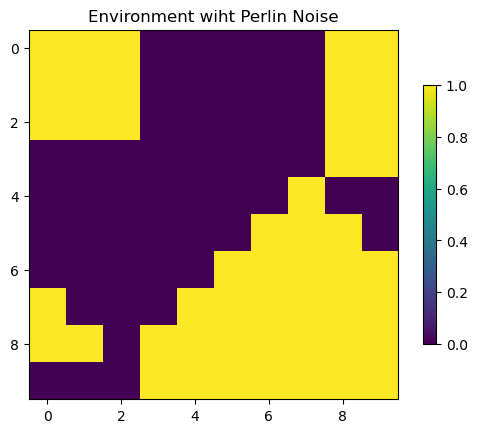

In [82]:
# Visualize Environment
fig = plt.figure()
plot = plt.imshow(env_initial[:, :, 2])
plt.title("Environment with Perlin Noise")
fig.colorbar(plot, shrink=0.7)

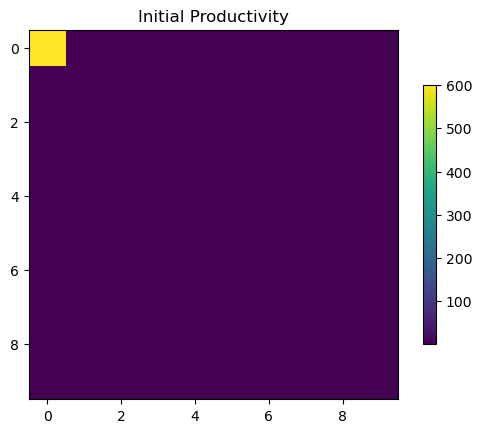

In [83]:
fig = plt.figure()
pp = plt.imshow(prod_initial)
plt.title("Initial Productivity")
fig.colorbar(pp, shrink=0.7)

In [142]:
# Updating the population dynamics
time_steps = 5_000
rate = 1 / 30 # Growth coefficient in equation (1) - related to time_steps
epsilon = 1e-3

def update_population(pop_current, prod, rate=0.1, epsilon=None):
    """Updates the population according to discrete solution of logistic ODE.
    If prod << 1, then the population will turn negative if non-zero (as e.g. after a split).
    To avoid this, we clip the population to zero.
    To avoid division by zero error, we add an epsilon to the divisor.
    Alternatively, we can clip to e.g. -100 to distinguish "dead" from empty villages.
    """
    pop_new = pop_current + rate * pop_current * (1 - pop_current / (prod + epsilon))
    return np.clip(pop_new, -100, None)

pop_t = np.zeros((time_steps, M, M))
pop_0 = np.zeros((M, M))
pop_0[0, 0] = 1 # populate upper-left edge
pop_t[0] = pop_0

In [143]:
has_empty_neighbors = np.ones((M, M)) # whether a village has empty neighbors
has_empty_neighbors = has_empty_neighbors > 0
prob_floats = rng.uniform(low=0.0, high=1.0, size=(M, M)) # draw floats from uniform distribution [0, 1]
p_flip = None

env_current = np.copy(env_initial)
skill_current = np.copy(skill_initial)
prod_current = np.copy(prod_initial)

cell_is_empty = np.zeros((M, M)) # whether a village IS empty
cell_is_empty[0, 0] = 1 # all cells except upper left are empty
cell_is_empty = cell_is_empty == 0

for i in range(1, time_steps):
    # Calculate productivity for iteration
    if p_flip is not None:
        env_current = flip_entries(env_current, p_flip=p_flip)
        # currently flips all values, i.e. also (0, 0, 0) where there is no population
        skill_current = flip_entries(skill_current, p_flip=p_flip)
    prod_current = get_productivity(skill_current, env_current, prod_current, prod_scale=p_0, prod_min=p_min)

    # Update population
    pop_t[i] = update_population(pop_t[i-1], prod_current, rate=rate, epsilon=epsilon)

    # Get split probability
    prob_split = p_split(pop_t[i])
    cell_is_split = prob_split > prob_floats
    rows_nonzero, cols_nonzero = np.nonzero(cell_is_split)

    # Loop through non-zero cells
    for r, c in zip(rows_nonzero, cols_nonzero):
            if not has_empty_neighbors[r, c]:
                continue

            # neighbors = np.array([[r, max(0, c-1)], [r, min(c+1, M-1)], [max(0, r-1), c], [min(M-1, r+1), c]]) # left, right, top, down
            # neighbors = remove_all_indices(neighbors, [r, c])

            neighbors = [[r, max(0, c-1)], [r, min(c+1, M-1)], [max(0, r-1), c], [min(M-1, r+1), c]] # left, right, top, down
            neighbors = remove_entry_from_list(neighbors, [r, c])

            # randomly select, check if empty, and pop
            # while neighbors.size > 0:
            while any(neighbors): # nested list is non-empty
                r0, c0 = random.choice(neighbors)
                if cell_is_empty[r0, c0]:
                    new_pop = pop_t[i, r, c] / 2
                    pop_t[i, r, c] = new_pop
                    pop_t[i, r0, c0] = new_pop
                    cell_is_empty[r0, c0] = False

                    # Add skill to new cell - identical to skill from old cell
                    skill_current[r0, c0] = skill_current[r, c]
                    break
                else:
                    # neighbors = remove_all_indices(neighbors, [r0, c0])
                    neighbors = remove_entry_from_list(neighbors, [r0, c0])

            # if no neighbors: remove from list to not search again
            # if neighbors.size == 0:
            if not any(neighbors):
                has_empty_neighbors[r, c] = False


Text(0.5, 1.0, 'Population dynamics for a selected cell')

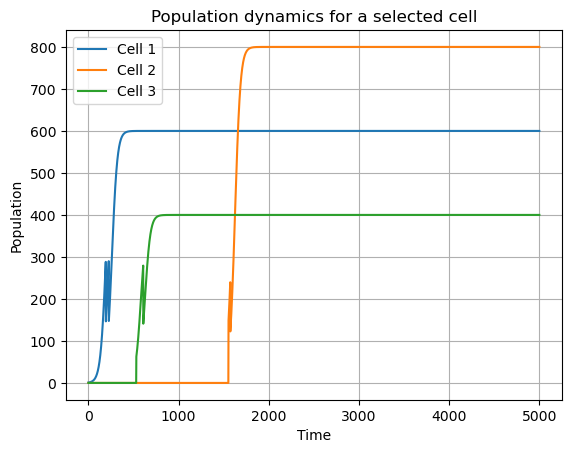

In [144]:
plt.plot(pop_t[:, 0, 0], label="Cell 1")
plt.plot(pop_t[:, 2, 9], label="Cell 2")
plt.plot(pop_t[:, 3, 5], label="Cell 3")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Population")
plt.grid()
plt.title("Population dynamics for a selected cell")

Text(0.5, 1.0, 'Final productivity')

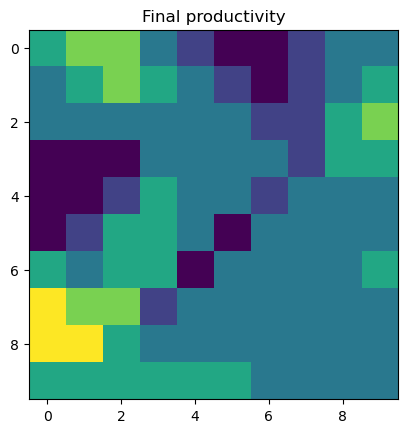

In [145]:
plt.imshow(prod_current)
plt.title("Final productivity")

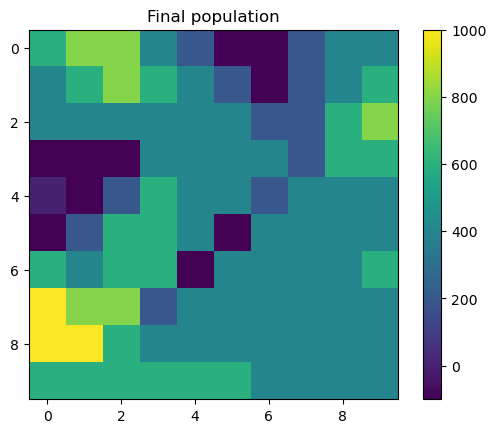

In [146]:
fig = plt.figure()

pp = plt.imshow(pop_t[-1])
plt.title("Final population")
fig.colorbar(pp)

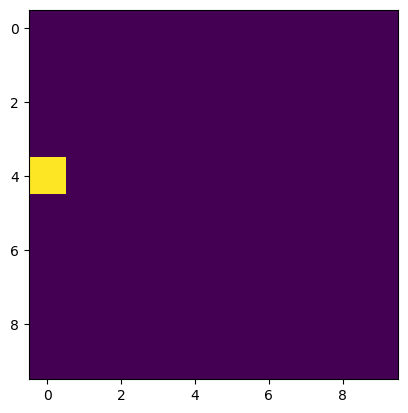

In [147]:
plt.imshow(cell_is_empty)

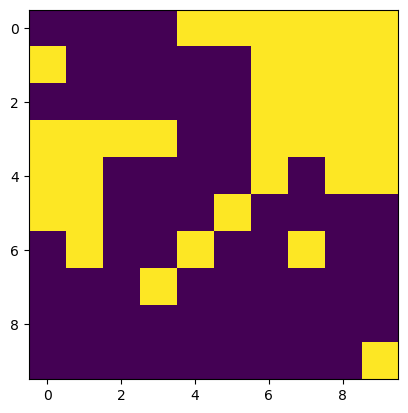

In [128]:
plt.imshow(has_empty_neighbors)